In [2]:
!pip install -Uqq ipdb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import numpy as np
import ipdb
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Finding Historical Data From Yahoo**

In [ ]:
META = yf.Ticker('META')

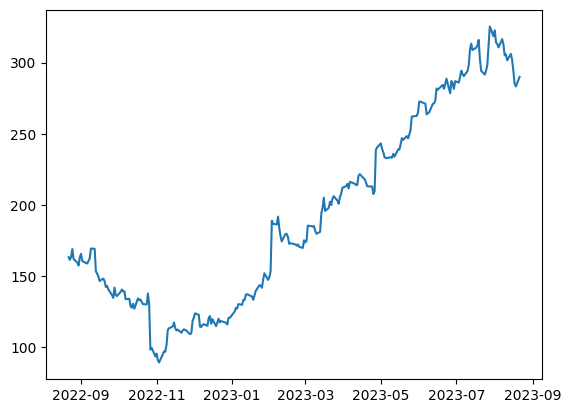

In [4]:
plt.plot(META.history(period = '1y')['Close'])

Selecting 20 Stocks with a similar P/E Ratio

In [5]:
def findStocks(names):
  stockList = []
  ratios = []
  count = 0
  for i in names:
    print(i)
    count+=1
    stock_info = yf.Ticker(i).info
    #ipdb.set_trace()

    PE = stock_info["forwardPE"]
    if PE > 20:
      if len(stockList) < 15:
        stockList.append(i)
        ratios.append(PE)
      elif PE < np.max(ratios):
        a = ratios.index(np.max(ratios))
        ratios[a] = PE
        stockList[a] = i
  return stockList

In [ ]:
data= pd.read_csv("/content/gdrive/MyDrive/constituents_csv.csv")
names = data["Symbol"].tolist()
myList = findStocks(names)

In [7]:
for i in myList:
  stock_info = yf.Ticker(i).info
  PE = stock_info["forwardPE"]
  print(i, PE)

INTC 20.456789
TT 20.497932
ORCL 20.136442
ATVI 20.524887
AMAT 20.777933
HD 20.053217
HSY 20.958334
FTV 20.614555
FCX 20.171875
RVTY 20.447037
MAR 20.944445
UNP 20.892723
AON 20.17134
BDX 20.355982
HRL 20.712765


Using an LSTM model to forecast META stock prices

In [8]:
df = yf.Ticker('META').history(period = '1y')

df= df.reset_index()
df = df[['Date', 'Close']]
df['Date'] =pd.to_datetime(df['Date']).dt.date
df.index = df.pop('Date')
df2 = df['Close'].pct_change()
df2 = df2.reset_index()
df2.drop(index=df2.index[0], axis=0, inplace=True)
df2 = df2.rename(columns={"Close": "Stock Return"})
df2.index = df2.pop('Date')
print(df)





                 Close
Date                  
2022-08-22  163.050003
2022-08-23  161.110001
2022-08-24  163.259995
2022-08-25  168.779999
2022-08-26  161.779999
...                ...
2023-08-15  301.950012
2023-08-16  294.290009
2023-08-17  285.089996
2023-08-18  283.250000
2023-08-21  289.899994

[251 rows x 1 columns]


In [9]:
def createWindowedDF_Prices(data, n = 3):
  windowedData = pd.DataFrame()
  for i in range(n,0,-1):
    windowedData[f'Target-{i}'] = data['Close'].shift(i)
  windowedData['Target'] = data['Close']
  return windowedData.dropna()

In [10]:
windowedDF = createWindowedDF_Prices(df)
windowedDF = windowedDF.reset_index()

windowedDF



,Date,Target-3,Target-2,Target-1,Target
0,2022-08-25,163.050003,161.110001,163.259995,168.779999
1,2022-08-26,161.110001,163.259995,168.779999,161.779999
2,2022-08-29,163.259995,168.779999,161.779999,159.169998
3,2022-08-30,168.779999,161.779999,159.169998,157.160004
4,2022-08-31,161.779999,159.169998,157.160004,162.929993
...,...,...,...,...,...
243,2023-08-15,305.739990,301.640015,306.190002,301.950012
244,2023-08-16,301.640015,306.190002,301.950012,294.290009
245,2023-08-17,306.190002,301.950012,294.290009,285.089996
246,2023-08-18,301.950012,294.290009,285.089996,283.250000


In [78]:
def windowToDateXY(data):
  df_as_np = data.to_numpy()
  dates = df_as_np[:,0]
  mid_matrix = df_as_np[:, 1:-1]
  x = mid_matrix.reshape((len(dates),mid_matrix.shape[1], 1))
  y = df_as_np[:, -1]
  return dates, x.astype(np.float32), y.astype(np.float32)

dates,x,y = windowToDateXY(windowedDF)

dates.shape, x.shape, y.shape


((248,), (248, 3, 1), (248,))

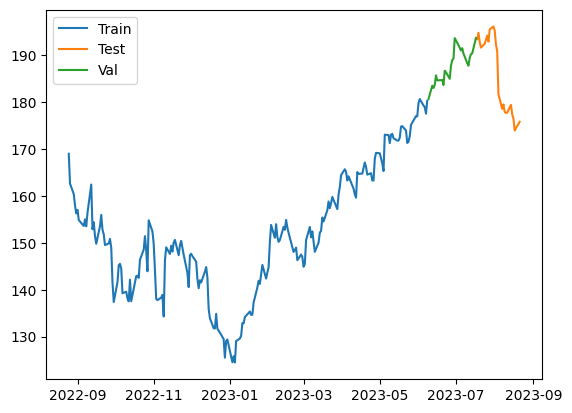

In [79]:
q_80 = int(len(dates) * 0.80)
q_90 = int(len(dates)*0.9)
dates_train, x_train, y_train = dates[:q_80], x[:q_80], y[:q_80]
dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]
dates_test, x_test, y_test = dates[q_90:], x[q_90:], y[q_90:]

plt.plot(dates_train,y_train, label = 'Train')

plt.plot(dates_test,y_test, label = 'Test')

plt.plot(dates_val,y_val, label = "Val")
plt.legend()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


model = Sequential([layers.Input((3,1)), layers.LSTM(64), layers.Dense(32, activation = 'relu'), layers.Dense(32, activation = 'relu'),  layers.Dense(1)])

model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.001), metrics = ['mean_absolute_error'])
model.save_weights('model.h5')

model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs = 100)

7/7 [==============================] - 1s 3ms/step


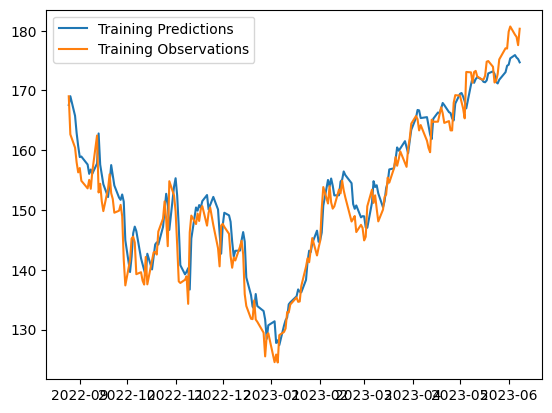

In [82]:
train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 22ms/step


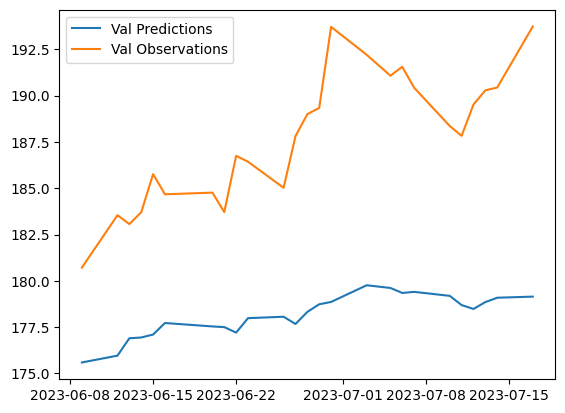

In [83]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Val Predictions', 'Val Observations'])

1/1 [==============================] - 0s 24ms/step


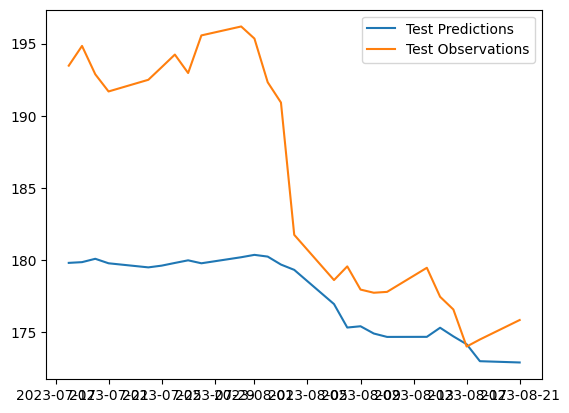

In [84]:
test_predictions = model.predict(x_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val,dates_test])
last_window = deepcopy(x_train[-1])

for target_date in recursive_dates:
  next = model.predict(np.array([last_window[-3:]])).flatten()
  recursive_predictions.append(next)
  last_window= np.concatenate((last_window,[next]))




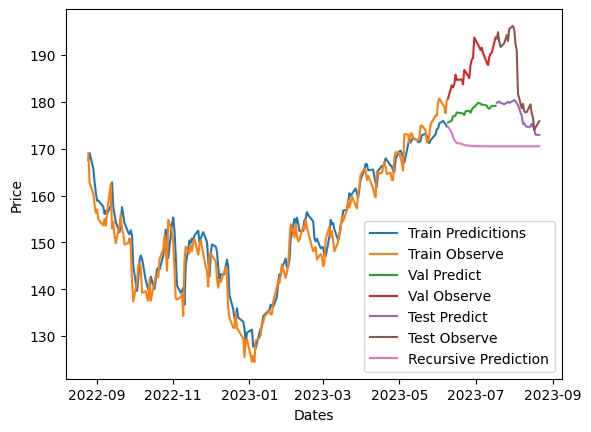

In [86]:
from datetime import date
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend(['Train Predicitions', 'Train Observe','Val Predict', 'Val Observe', 'Test Predict', 'Test Observe', 'Recursive Prediction'])


Using a normal distribution to predict Stock Returns


Text(0, 0.5, 'Bin Count')

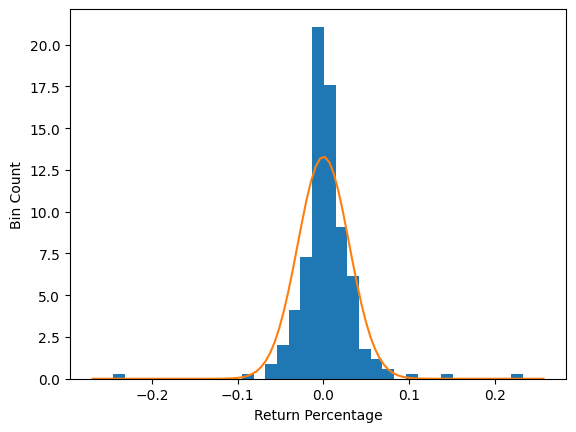

In [88]:
from scipy.stats import norm

plt.hist(df2['Stock Return'], bins = 35, density = True)
mean, std = norm.fit(df2['Stock Return'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, np.round(mean,2), np.round(std,2))
plt.plot(x, y, label = 'Normal PDF')

plt.xlabel('Return Percentage')
plt.ylabel('Bin Count')


#As shown the normal distribution is a good fit for stock returns


Picking 5 Stocks based on Expected Values of the Returns

In [20]:
def selectStock_Returns(stockList):

  finList = []
  means = []
  for i in stockList:
    stockInfo= yf.Ticker(i).history(period = '1y')
    stockInfo = stockInfo.reset_index()
    stockInfo = stockInfo[['Date', 'Close']]
    df = stockInfo['Close'].pct_change()
    df = df.reset_index()
    df.drop(index=df.index[0], axis=0, inplace=True)
    df = df.rename(columns={"Close": "Stock Return"})
    returnMean = np.mean(df['Stock Return'])
    if len(finList) < 5:
      finList.append(i)
      means.append(returnMean)
    elif returnMean > np.min(means):
      a = means.index(np.min(means))
      means[a] = returnMean
      finList[a] = i

  return finList, means


In [21]:
print(selectStock_Returns(myList))

(['MAR', 'TT', 'ORCL', 'FCX', 'AMAT'], [0.0011435844534595137, 0.0010848269605386652, 0.001885359793868845, 0.0014968329608911356, 0.001932729850569696])



Selecting 5 Stocks based on LSTM predictions





In [22]:

from datetime import timedelta

startDate = date.today()
change = timedelta(days = 30)
endDate = startDate + change
futureDates = []

while startDate <= endDate:
  futureDates.append(startDate)

  startDate += timedelta(days = 1)


def train_stock_model(stock_symbol, x_train, y_train, x_val, y_val):
    model = Sequential([layers.Input((3, 1)), layers.LSTM(64), layers.Dense(32, activation='relu'),
                        layers.Dense(32, activation='relu'), layers.Dense(1)])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)
    return model


def make_recursive_predictions(model, x_val, future_dates):
    recursive_predictions = []
    last_window = deepcopy(x_val[-1])

    for _ in range(len(future_dates)):
        next = model.predict(np.array([last_window[-3:]])).flatten()
        recursive_predictions.append(next)
        last_window = np.concatenate((last_window, [next]))

    return recursive_predictions



def predict_future_stock_prices(stock_list, future_dates):
    predictions = []

    for symbol in stock_list:
        stock_info = yf.Ticker(symbol)
        hist = stock_info.history(period='1y')
        hist = hist.reset_index()
        df = hist[['Date', 'Close']]
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        df.index = df.pop('Date')

        windowedDF = createWindowedDF_Prices(df)
        windowedDF = windowedDF.reset_index()

        dates, x, y = windowToDateXY(windowedDF)

        q_85 = int(len(dates) * 0.85)
        dates_train, x_train, y_train = dates[:q_85], x[:q_85], y[:q_85]
        dates_val, x_val, y_val = dates[q_85:], x[q_85:], y[q_85:]

        model = train_stock_model(symbol, x_train, y_train, x_val, y_val)

        recursive_predictions = make_recursive_predictions(model, x_val, future_dates)

        predictions.append(recursive_predictions)

    return predictions


def selectStocks_Prices(LIST,future_dates):
  modelPredictions = []
  count = 0
  finList = []
  bestPrices = []
  futurePredictions = predict_future_stock_prices(LIST, future_dates)

  for i in LIST:
    df = yf.Ticker(i).history(period = '5d')
    percentIncrease = (futurePredictions[count][-1])/ (df['Close'].iloc[-1])

    if len(finList) < 5:
      finList.append(i)
      bestPrices.append(percentIncrease)
      modelPredictions.append(futurePredictions[count])

    elif percentIncrease > np.min(bestPrices):
      a = bestPrices.index(np.min(bestPrices))
      finList[a] = i
      bestPrices[a] = percentIncrease
      modelPredictions[a] = futurePredictions[count]

    count+=1

  return finList, bestPrices, modelPredictions




In [ ]:

LSTMList,Increases,LSTMPredictions = selectStocks_Prices(myList,futureDates)

[1.010182]


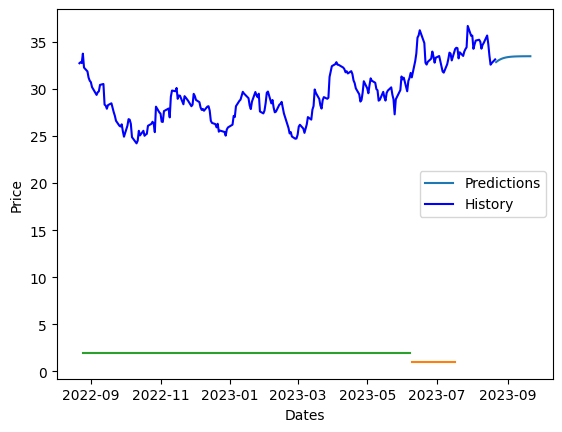

In [91]:
index = 0

hist = yf.Ticker(LSTMList[index]).history(period = '1y')
print(Increases[index])

plt.plot(futureDates, LSTMPredictions[index], label = 'Predictions')
plt.plot(hist['Close'], color = 'blue', label = 'History')


plt.plot(dates_val,np.linspace(1,1,len(dates_val)))
plt.plot(dates_train, np.linspace(2,2,len(dates_train)))

plt.ylabel('Price')
plt.xlabel('Dates')
plt.legend()


In [52]:
print(LSTMList)

['INTC', 'RVTY', 'ORCL', 'HRL', 'FCX']
